In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import warnings
import h5py
import pandas as pd
import scipy.interpolate as scintrp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import savgol_filter as smooth

import foam
import windPlotting as wPlt
import wind

import winsound

In [3]:
def convertDFSR_out_toNPY(inflDir, sampleName):
    # 
    probes, time, UofT = foam.__readProbe_singleT(inflDir+sampleName+'/Ux','p')
    print('Finished reading UofT')
    _, _, VofT = foam.__readProbe_singleT(inflDir+sampleName+'/Uy','p')
    print('Finished reading VofT')
    _, _, WofT = foam.__readProbe_singleT(inflDir+sampleName+'/Uz','p')
    print('Finished reading WofT')

    UofT = np.transpose(UofT)
    VofT = np.transpose(VofT)
    WofT = np.transpose(WofT)

    np.save(inflDir+sampleName+'/time.npy',time)
    np.save(inflDir+sampleName+'/probes.npy',probes)
    np.save(inflDir+sampleName+'/UofT.npy',UofT)
    np.save(inflDir+sampleName+'/VofT.npy',VofT)
    np.save(inflDir+sampleName+'/WofT.npy',WofT)

    winsound.Beep(1000, 1000)

def saveFoamCaseTH_toFile(caseDir, probeName, H,):
    les_x0 = foam.processVelProfile(caseDir,probeName=probeName,name="___",exportPlots=False, trimTimeSegs=[[0,1.0]],H=H, showLog=False)
    np.save(caseDir+probeName+'_time.npy',les_x0.t)
    np.save(caseDir+probeName+'_Z.npy',les_x0.Z)
    np.save(caseDir+probeName+'_UofT.npy',les_x0.UofT)
    np.save(caseDir+probeName+'_VofT.npy',les_x0.VofT)
    np.save(caseDir+probeName+'_WofT.npy',les_x0.WofT)



In [4]:
raw_wtFile_fine = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Fr1_forPython.mat"
raw_wtFile_med2 = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Mr2_forPython.mat"
raw_wtFile_med3 = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Mr3_forPython.mat"
dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"

lScl=0.02
H = 0.08


# Load the target wind field

The current profile data has already been scaled in Matlab. The cobra probe $U_h$ was around 7 $m/s$.

In [5]:
Uh_HFPI = 12.5
Uh_cobra = 7.6
vel_ratio = Uh_HFPI/Uh_cobra

data = h5py.File(raw_wtFile_fine, 'r')
print(data.keys())
Z = data['Z'][0]
U_TH = np.array(data['UofT']).copy()*vel_ratio
V_TH = np.array(data['VofT']).copy()*vel_ratio
W_TH = np.array(data['WofT']).copy()*vel_ratio
dt = data['dt'][0][0]/vel_ratio
wtVel_E2 = wind.profile(name="BLWT-E2 (F)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=16)
del U_TH, V_TH, W_TH

# data = h5py.File(raw_wtFile_med2, 'r')
# print(data.keys())
# Z = data['Z'][0]
# U_TH = np.array(data['UofT']).copy()
# V_TH = np.array(data['VofT']).copy()
# W_TH = np.array(data['WofT']).copy()
# dt = data['dt'][0][0]
# wtVel_M2 = wind.profile(name="BLWT-E2 (M2)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=16)
# del U_TH, V_TH, W_TH

# data = h5py.File(raw_wtFile_med3, 'r')
# print(data.keys())
# Z = data['Z'][0]
# U_TH = np.array(data['UofT']).copy()
# V_TH = np.array(data['VofT']).copy()
# W_TH = np.array(data['WofT']).copy()
# dt = data['dt'][0][0]
# wtVel_M3 = wind.profile(name="BLWT-E2 (M3)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=16)
# del U_TH, V_TH, W_TH

esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU85(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))

wt_vs_ESDU = wind.Profiles([wtVel_E2, esdu74_E2.toProfileObj(n=np.logspace(-2.5,1.5,100)), esdu85_E2.toProfileObj(n=np.logspace(-2.5,1.5,100))],)


<KeysViewHDF5 ['H', 'README', 'UofT', 'VofT', 'WofT', 'Z', 'dt', 'exposureName']>


In [6]:
inflowDir_E2 = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/"

infl_E2 = foam.inflowTuner(H=H, nSpectAvg=32,
                                target=wtVel_E2,)

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0')
infl_E2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0', name='DFSR.r0')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r1')
infl_E2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r1', name='DFSR.r1')

# infl_E2.addInflow(caseName=dir_wtVl_tngE2+r"inflow/", sampleName='sampledData_inflow1', name='old_DFSR')

infl_E2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v0/', probeName='prof_x0_y0', name='tngE2.ed.v0', showLog=True)
infl_E2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v1/', probeName='prof_x0_y0', name='tngE2.ed.v1', showLog=True)


Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v0/
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v0//postProcessing/prof_x0_y0
  >> Reading probe data ...
           Reading U from: D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v0//postProcessing/prof_x0_y0/0/U
                61 probes with 13916 time steps (0.0 to 2.783)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (13916, 61, 3)
           Reading U from: D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v0//postProcessing/prof_x0_y0/2.783/U
                61 probes with 6456 time steps (2.783 to 4.074)
                No. of overlapping time steps with previously read data: 1
                Shape of data: (6456, 61, 3)
           Reading U from: D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED/tngE2.ed.v0//postProcessing/prof

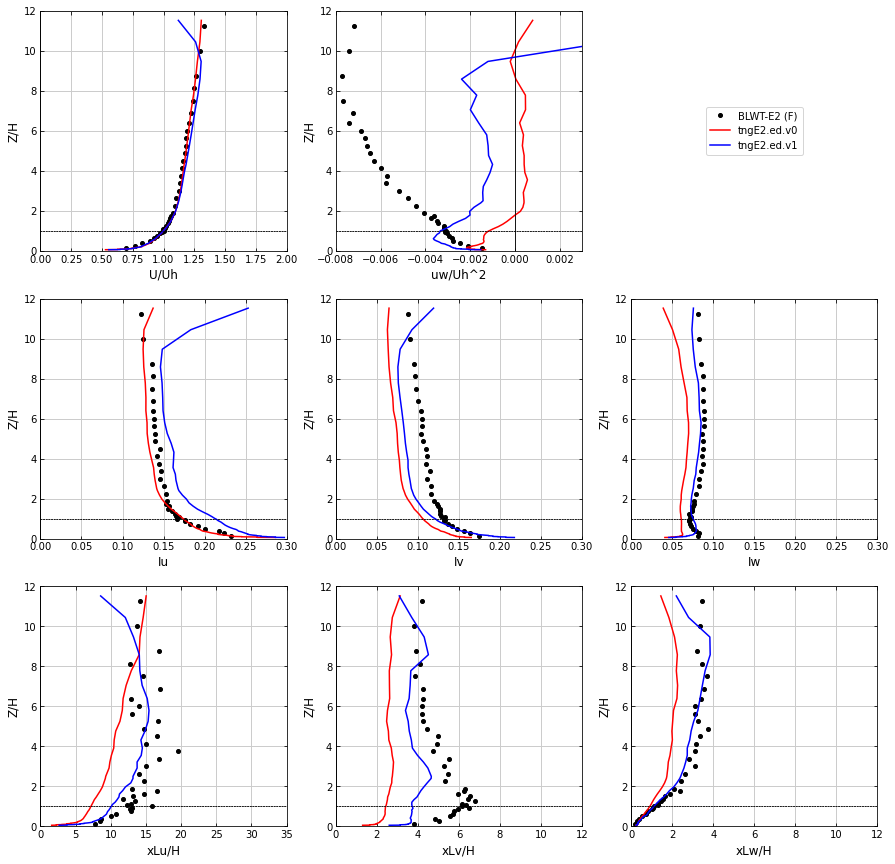

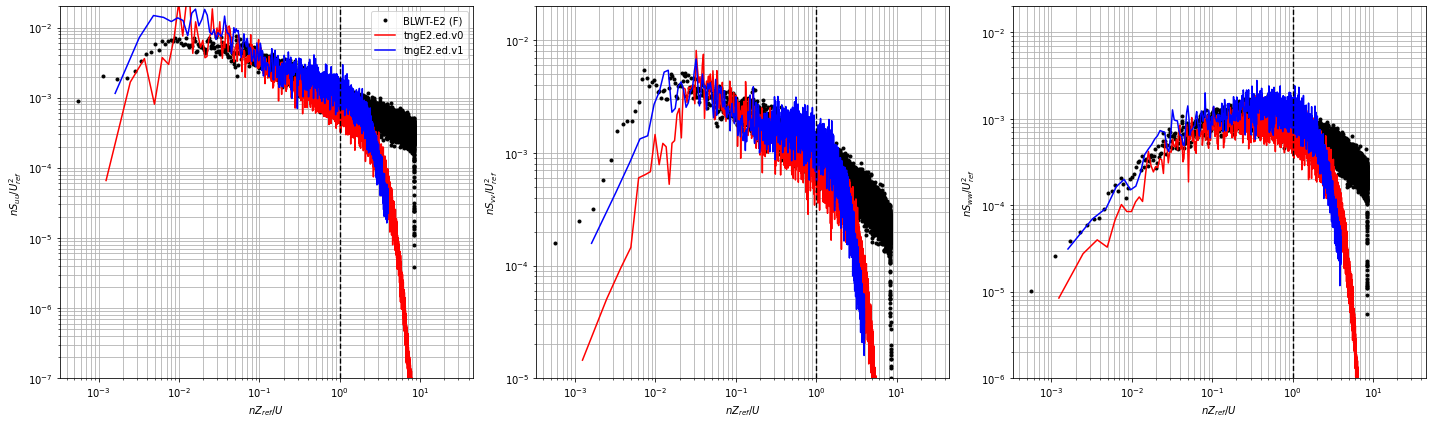

In [19]:
infl_E2.plotProfiles(figsize=[15,15], 
                        zLim=[0,12], 
                        xLimits_U=[0, 2], xLimits_uw=[-0.008, 0.003], 
                        xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.3], xLimits_Iw=[0,0.3], 
                        xLimits_xLu=[0, 35], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
                        includeInflows=False, includeIncidents=True, normalize=True,
                        ms=4, lw=1.5)

infl_E2.plotSpectra(figSize=[20,6],
                    includeInflows=False, includeIncidents=True,
                    yLimits=[[1e-7,2e-2],[1e-5,2e-2],[1e-6,2e-2]],)


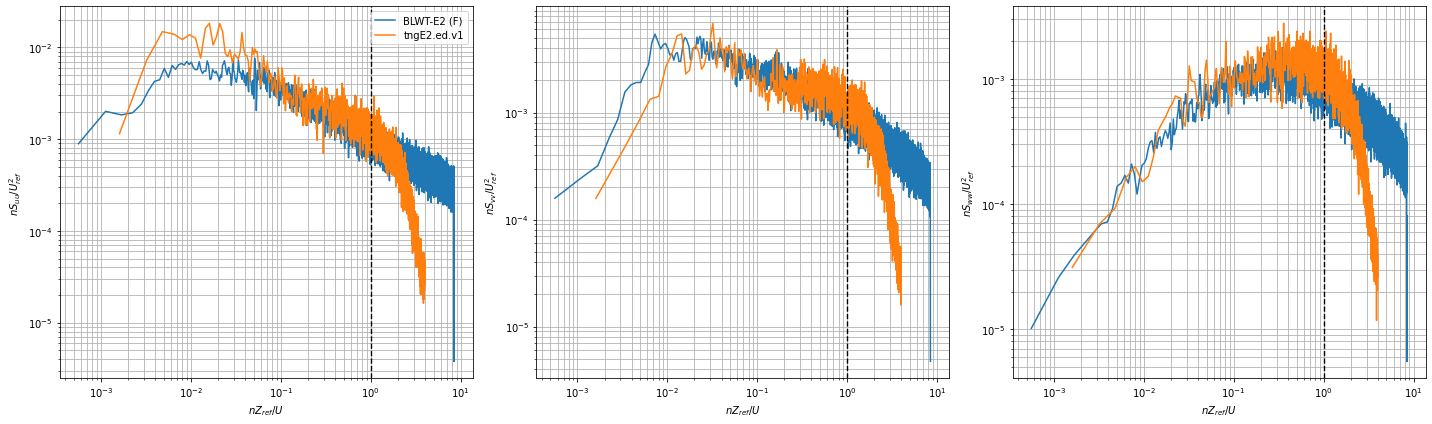

In [52]:
vel = wind.Profiles([infl_E2.target, infl_E2.incidents.profiles[1]])

vel.plotSpectra(figSize=[20,6],)

In [8]:
profs = wind.Profiles([wtVel_E2, infl_E2.incidents.profiles[1], 
                    #    infl_E2.incidents.profiles[1],
                    ],)
# profs.plotProfile_basic2(yLimits=[0,12])
# profs.plotSpectra(figSize=[20,6],
#     yLimits=[[1e-5,2e-2],[1e-5,2e-2],[1e-6,2e-2]],
#     smoothFactor=1500,)

# infl_E2.plotSpectra(figSize=[20,6], xLimits=[1e-4,30], yLimits=[[1e-5,2e-2],[1e-5,2e-2],[1e-6,2e-2]],)
print(f"Least sampling freq. = {10*wtVel_E2.Uh*2/wtVel_E2.H} Hz")
print(f"Max time step = {1/(10*wtVel_E2.Uh*2/wtVel_E2.H)} s")

Least sampling freq. = 3126.5664973668518 Hz
Max time step = 0.00031983967103920075 s


Profile written to: D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/tuning/infl.r2//profile


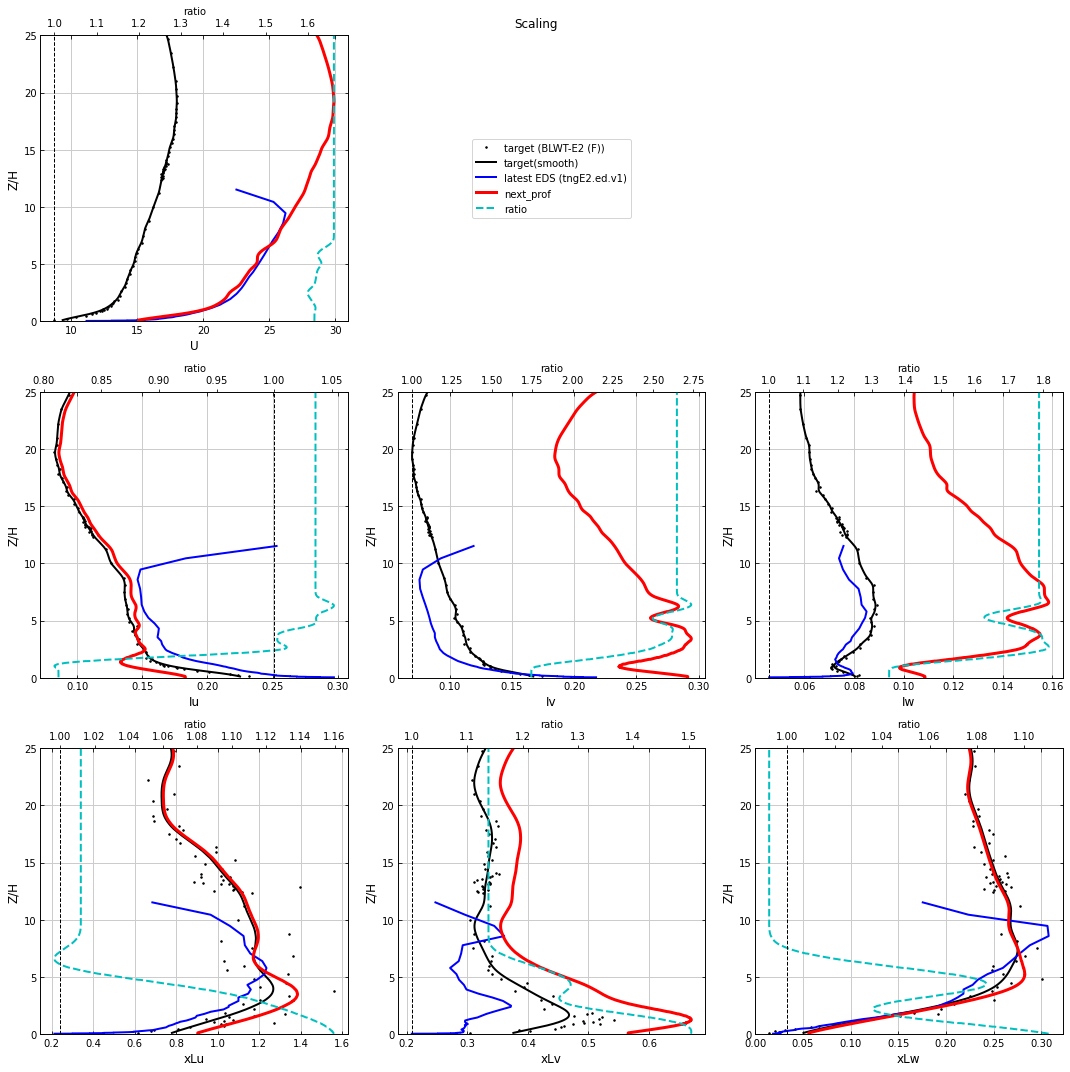

In [102]:
rnd = 2
prof = infl_E2.writeProfile(
                            # dir=inflowDir_E2 + f'tuning/infl.r{rnd}/', 
                            name='profile',
                            rounds=rnd, 
                            zLim=[0,25], 
                            debugMode=True,
                            applySmoothing=True,
                            applyLimitedSmoothing=False,
                            compensateFor_xLi_in_Ii=False,
                            zMin_scaling=0.08,
                            zMax_scaling=0.08*7,
                            scale_xLi=[False, True, False],
                            smoothWindow=[50, 50, 50, 50, 200, 150, 200],
                            figsize=[15,15])

In [10]:
inflowDir_E2_test = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/"

infl_seed = foam.inflowTuner(H=H, nSpectAvg=32,
                                target=wtVel_E2,)

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0')
infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0', name='DFSR.r0')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed1')
infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed1', name='DFSR.r0.seed1')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed2')
infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed2', name='DFSR.r0.seed2')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed3')
infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed3', name='DFSR.r0.seed3')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r1')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r1', name='DFSR.r1')



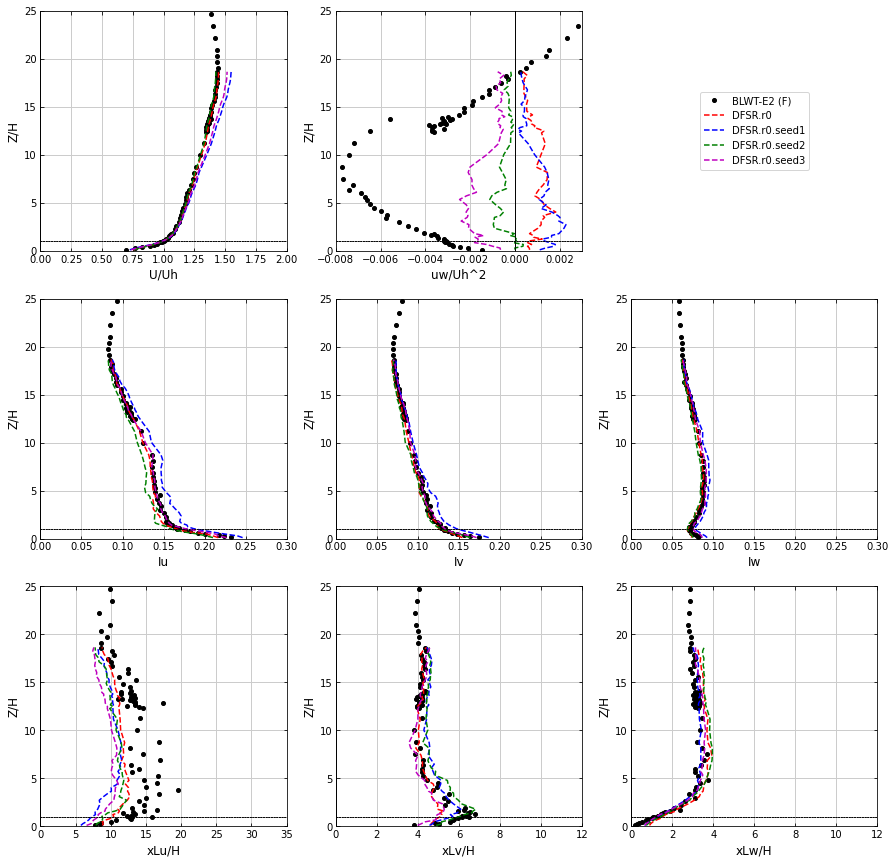

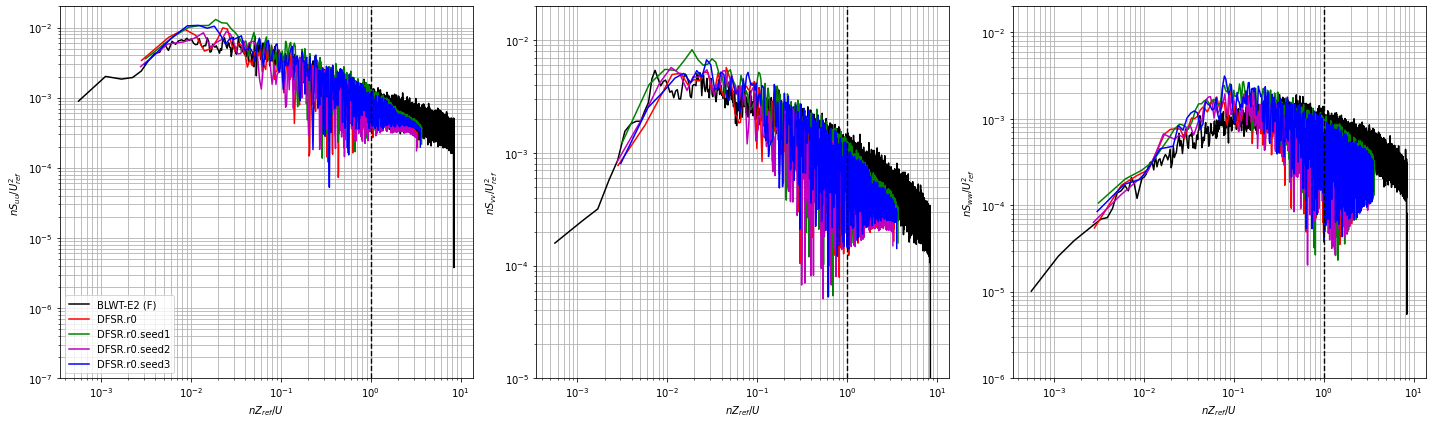

In [11]:
infl_seed.plotProfiles(figsize=[15,15], 
                        zLim=[0,25], 
                        xLimits_U=[0, 2], xLimits_uw=[-0.008, 0.003], 
                        xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.3], xLimits_Iw=[0,0.3], 
                        xLimits_xLu=[0, 35], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
                        includeInflows=True, includeIncidents=False, normalize=True,
                        ms=4, lw=1.5)
infl_seed.plotSpectra(figSize=[20,6],
                    includeInflows=True, includeIncidents=False,
                    yLimits=[[1e-7,2e-2],[1e-5,2e-2],[1e-6,2e-2]],)

Processing OpenFOAM case:	D:/tempData_depot/simData_FFS/FFS_ABL_inf/
Probe read from:		D:/tempData_depot/simData_FFS/FFS_ABL_inf//postProcessing/probes.zProfile.x0.0
  >> Reading probe data ...
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_inf//postProcessing/probes.zProfile.x0.0/0.495/U
                61 probes with 1032 time steps (0.495 to 0.7012)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (1032, 61, 3)
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_inf//postProcessing/probes.zProfile.x0.0/0.7/U
                61 probes with 1405 time steps (0.7 to 0.9808)
                No. of overlapping time steps with previously read data: 7
                Shape of data: (1405, 61, 3)
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_inf//postProcessing/probes.zProfile.x0.0/0.98/U
                61 probes with 1391 time steps (0.98 to 1.258)
                No. of overlapping t

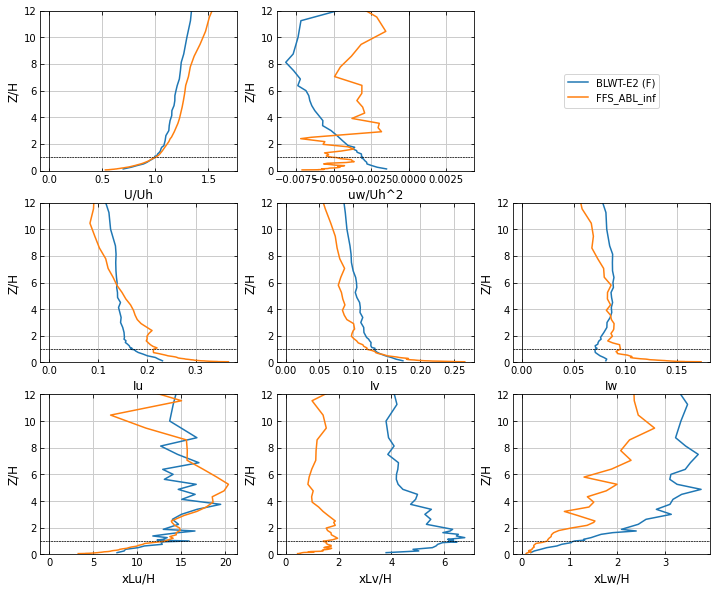

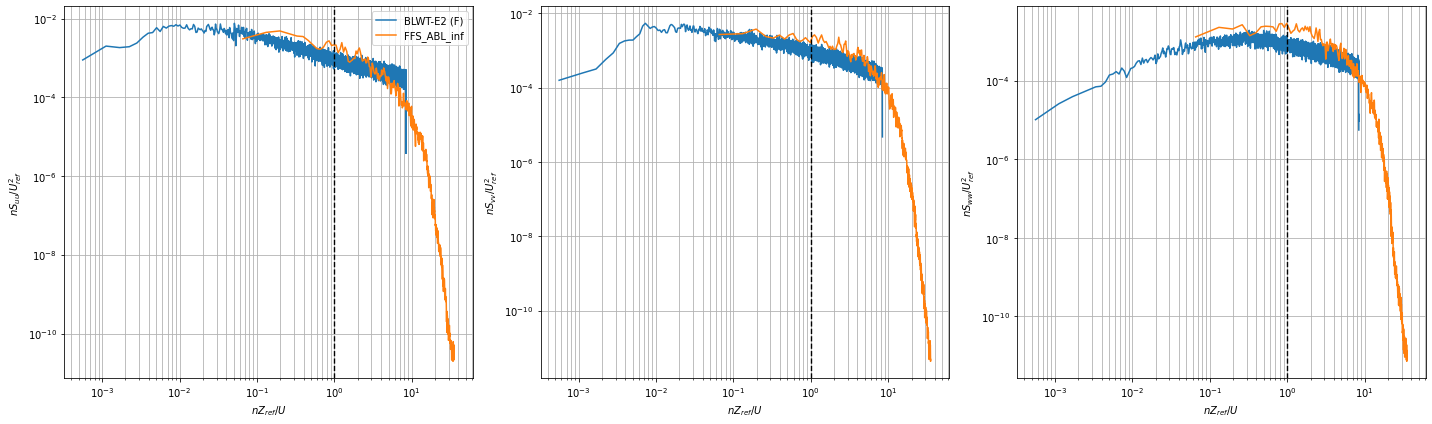

In [106]:
prof = foam.readVelProfile(caseDir=r'D:/tempData_depot/simData_FFS/FFS_ABL_inf/',
                           probeName=r'probes.zProfile.x0.0',
                           name='FFS_ABL_inf', 
                           showLog=True, 
                           trimTimeSegs=[[0,0.1],],
                           H=0.08)
profs = wind.Profiles([wtVel_E2, prof,])
profs.plotProfile_basic2(yLimits=[0,12])
profs.plotSpectra(figSize=[20,6],)